# Reinforcement Learning

**Universidad Nacional de Colombia - Sede Bogotá**  
**Introducción a la Inteligencia Artificial**

Sebastian Leonardo Molina Diaz  
[smolinad@unal.edu.co](smolinad@unal.edu.co)

## Setting up the environment

Verify that `Python` version is `3.10.*` or older, in order to use the `Gymnasium` library. The `Gymnasium` library is a fork of OpenAI `Gym`, a toolkit for implementing reinforcement algorithms.  See [Gymnasium Documentation](https://gymnasium.farama.org/) for more information. Also, we import relevant libraries into the environment.

In [1]:
!python -V

Python 3.9.9


In [2]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm
import numpy as np
import random

import gym

Now, we create a `Taxi` envieronment as required. Also, we fix the seed for `random` for reproducible results over different executions.

In [3]:
env = gym.make('Taxi-v3')

In [4]:
random.seed(10)

## $Q$-learning

The $Q$-learning is an algorithm that maximizes the rewards over a sequence of states and actions exectuted by an agent, independent of the probability of a transition from one state to the next. The algorithm, based on Bellman equation for optimization depends on the following formula:  

$$
Q^{\text {new }}\left(s_t, a_t\right) \leftarrow \underbrace{Q\left(s_t, a_t\right)}_{\text {current value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{\underbrace{r_t}_{\text {reward }}+\underbrace{\gamma}_{\text {discount factor }} \cdot \underbrace{\max _a Q\left(s_{t+1}, a\right)}_{\text {estimate of optimal future value }}}_{\text {new value (temporal difference target) }}-\underbrace{Q\left(s_t, a_t\right)}_{\text {current value }})}^{\text {temporal difference }}
$$

### Implementation & Training

Following instructions in [[1]](https://gymnasium.farama.org/tutorials/blackjack_tutorial/), we implement a Taxi Driver agent using the $Q$-learning algorithm:

In [6]:
class TaxiDriverQ:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [7]:
def train(env,
          n_episodes,
          learning_rate,
          start_epsilon,
          epsilon_decay,
          final_epsilon,
          discount_factor):

    agent = TaxiDriverQ(
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount_factor
    )
    
    res = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = res.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = res.step(action)

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()
        
    return agent, res

First we train the Taxi Driver agent to reward the future actions higher, setting the discount factor $\gamma$ to a high value:

In [8]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.95

agent, res = train(env,
                   n_episodes,
                   learning_rate,
                   start_epsilon,
                   epsilon_decay,
                   final_epsilon,
                   discount_factor)

100%|██████████████████████████████████████████████████████████████| 100000/100000 [03:34<00:00, 465.93it/s]


### Results

Using the Statistics Record wrapper, we can obtain the cumulative rewards, episode lenghts and training errors:

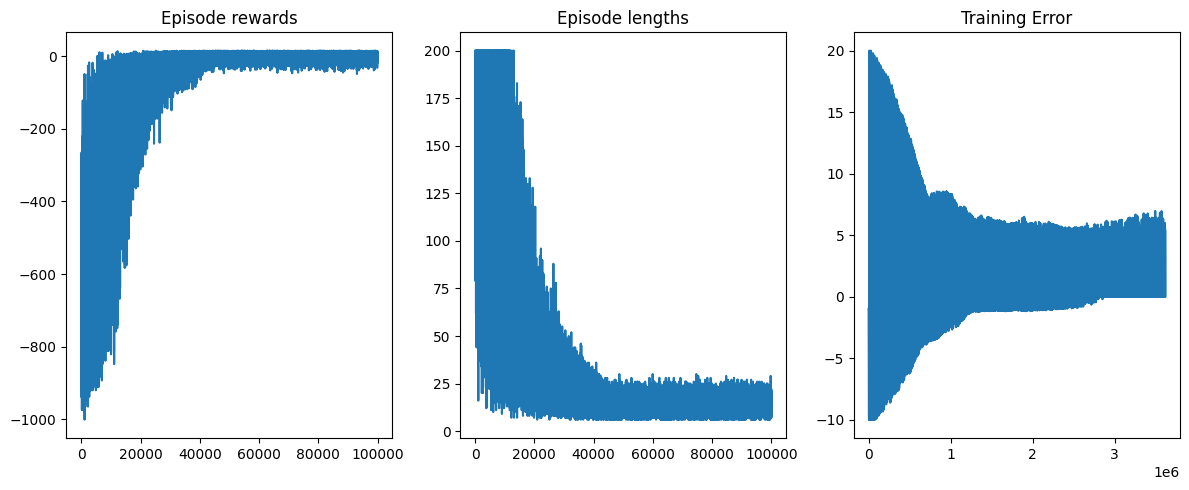

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = np.array(res.return_queue).flatten()
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = np.array(res.length_queue).flatten()
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = np.array(agent.training_error)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

Using rolling average —*i.e.*, applying convolution to the results obtained by the Taxi environment wrapper— to denoise the results, we can clearly see that episode rewards eventually converge to 0, episode lenghts become shorter and the training error is diminished.

In [10]:
def plot_denoised_res(agent, res):
    rolling_length = 300

    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    reward_moving_average = np.convolve(
        np.array(res.return_queue).flatten(), np.ones(rolling_length)/rolling_length, mode="valid"
        )

    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

    
    axs[1].set_title("Episode lengths")
    length_moving_average = np.convolve(
            np.array(res.length_queue).flatten(), np.ones(rolling_length)/rolling_length, mode="same"
        )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)

    
    axs[2].set_title("Training Error")
    training_error_moving_average = np.convolve(
        np.array(agent.training_error), np.ones(rolling_length)/rolling_length, mode="same"
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.show()

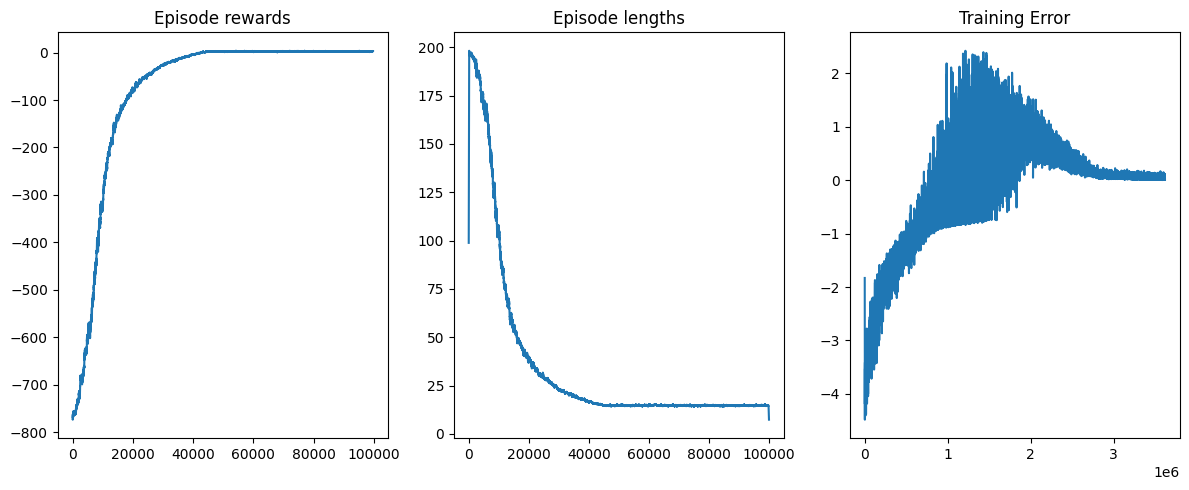

In [11]:
plot_denoised_res(agent, res)

Also, —why not?— we trained the agent to reward higher the instantaneous actions with a really low discount factor.

In [12]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.05

agent, res = train(env,
                   n_episodes,
                   learning_rate,
                   start_epsilon,
                   epsilon_decay,
                   final_epsilon,
                   discount_factor)

100%|██████████████████████████████████████████████████████████████| 100000/100000 [07:58<00:00, 208.96it/s]


We can see in the resulting plots that convergence to episode rewards is more gentle than in the previous training, and doesn't quite reach the 0 score. Also, episode lengths seem to be longer as execution time is almost 4 minutes longer

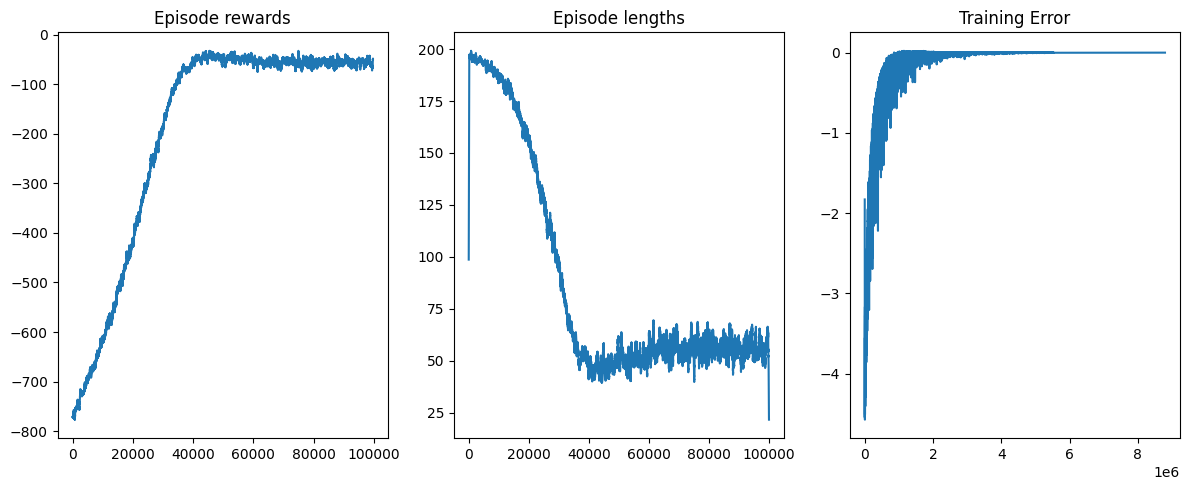

In [13]:
plot_denoised_res(agent, res)

## References 

[1] Solving Blackjack with Q-Learning. *Gymnasium Documentation*. Retrieved from: [https://gymnasium.farama.org/tutorials/blackjack_tutorial/]().